線形回帰を行うときの重要な仮定は

* 残差が独立同分布になっている

である.  よく言われている条件

* 残差が正規分布に従うこと

は必須の条件ではない.  残差が正規分布に従うことは必要ないし, 残差の分布が正規分布に従っていても i.i.d. になっていなければ線形回帰の適用は不適切であると考えられる.

もちろん, 残差が正規分布以外の分布のi.i.d.になっている場合には, 誤差が大きくなることはありえるので要注意である.

残差が正規分布以外の分布のi.i.d.になっているように見える場合には, 観測していない独立変数に $y$ が非線形に依存している可能性を疑う必要があるかもしれない.

In [1]:
using Distributions
using Optim
using Random
using StatsFuns
using StatsPlots
default(fmt=:png, titlefontsize=10, tickfontsize=6, guidefontsize=8, legendfontsize=8)

β̂ = X \ y = [2.0373577494639292, 1.9542255204514933]


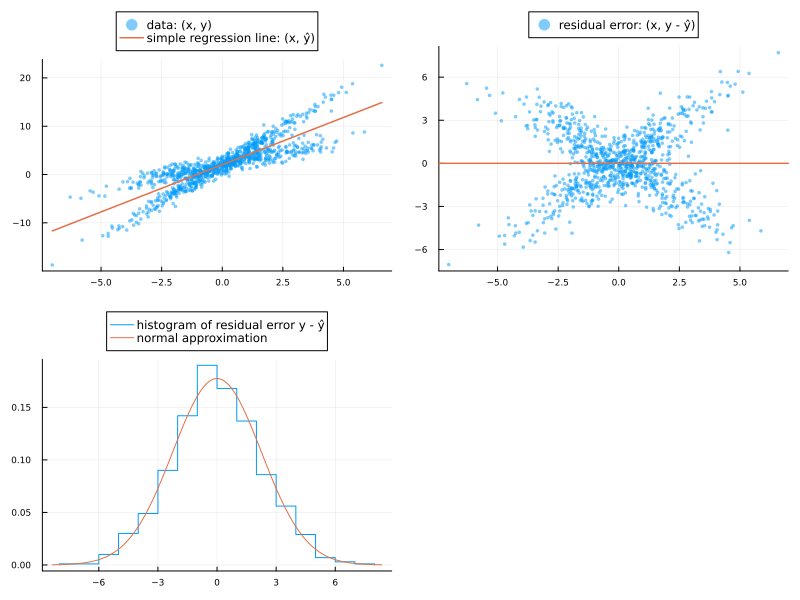

In [2]:
Random.seed!(4649373)

n = 10^3

distx = Normal(0, 2)

disty(x,a,b,c,d,s,t) = MixtureModel(
    [Normal(a + b*x, exp(s)), Normal(c + d*x , exp(t))],
    fill(1/2, 2))

w_true = Float64[2, 1, 2, 3, 0, 0]
x = rand(distx, n)
y = @. rand(disty(x, w_true...))
X = x .^ (0:1)'
@show β̂ = X \ y
ŷ = X * β̂

P1 = scatter(x, y; label="data: (x, y)", msc=:auto, alpha=0.5, ms=2)
plot!(x -> [1,x]'*β̂; label="simple regression line: (x, ŷ)", lw=1.5)

P2 = scatter(x, y - ŷ; label="residual error: (x, y - ŷ)", msc=:auto, alpha=0.5, ms=2)
hline!([0]; label="", lw=1.5)

P3 = stephist(y - ŷ; norm=true, label="histogram of residual error y - ŷ")
plot!(fit(Normal, y - ŷ); label="normal approximation")

plot(P1, P2, P3; size=(800, 600), legend=:outertop, layout=(2, 2))

上のデータに単純に線形回帰を適用することは散布図より明らかだが, 残差の全体は正規分布に従っている.

  1.981295 seconds (3.90 M allocations: 270.117 MiB, 7.40% gc time)
o =  * Status: success

 * Candidate solution
    Final objective value:     -5.244561e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 8.73e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.96e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.97e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.71e-14 ≰ 0.0e+00
    |g(x)|                 = 1.34e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    20
    ∇f(x) calls:   20

(â, b̂, ĉ, d̂) = o.minimizer = [2.0189805949590696, 1.097398403965397, 2.0414557897293157, 2.944621720997785]


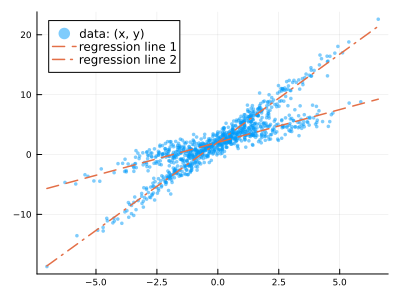

In [3]:
disty(x,a,b,c,d,s,t) = MixtureModel(
    [Normal(a + b*x, exp(s)), Normal(c + d*x , exp(t))],
    fill(1/2, 2))

negloglik(a, b, c, d, s, t) = -logsumexp(logpdf(disty(x,a,b,c,d,s,t), y) for (x, y) in zip(x, y))
@time o = optimize(w -> negloglik(w..., 0, 0), w_true[1:4], LBFGS())
@show o
@show â, b̂, ĉ, d̂ = o.minimizer

Q1 = scatter(x, y; label="data: (x, y)", msc=:auto, alpha=0.5, ms=2)
plot!(x -> â + b̂*x; label="regression line 1", ls=:dash, lw=1.5, c=2)
plot!(x -> ĉ + d̂*x; label="regression line 2", ls=:dashdot, lw=1.5, c=2)
plot!(size=(400, 300))

以下は残差が非正規分布になっている場合.

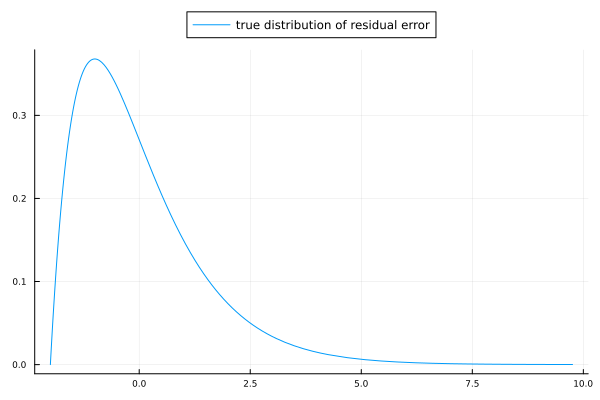

In [4]:
distx = Normal(0, 2)
_distu = Gamma(2, 1)
distu = _distu - mean(_distu)

plot(distu; label="true distribution of residual error", legend=:outertop)

β̂ = X \ y = [0.9980402018568433, 1.0062851425605863]


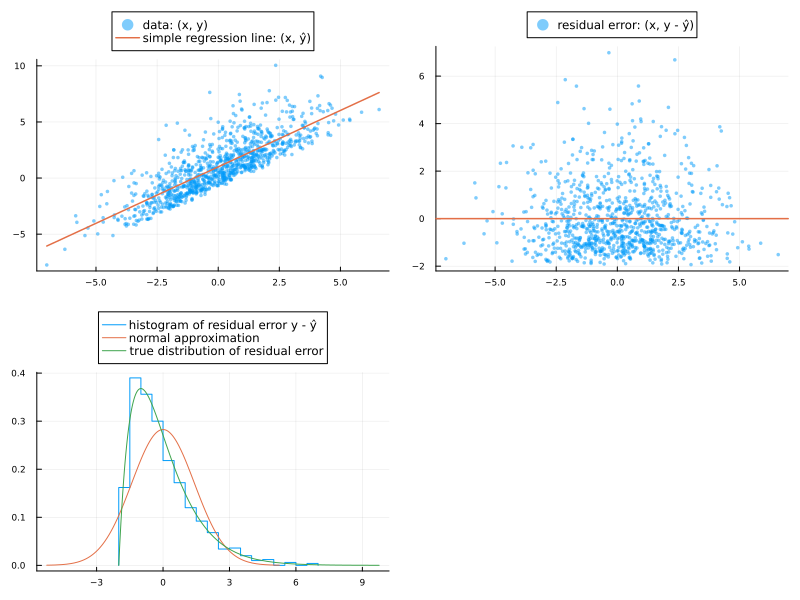

In [5]:
n = 1000
a, b = 1.0, 1.0
y = @. a + b*x + rand(distu)

X = x .^ (0:1)'
@show β̂ = X \ y
ŷ = X * β̂

P1 = scatter(x, y; label="data: (x, y)", msc=:auto, alpha=0.5, ms=2)
plot!(x -> [1,x]'*β̂; label="simple regression line: (x, ŷ)", lw=1.5)

P2 = scatter(x, y - ŷ; label="residual error: (x, y - ŷ)", msc=:auto, alpha=0.5, ms=2)
hline!([0]; label="", lw=1.5)

P3 = stephist(y - ŷ; norm=true, label="histogram of residual error y - ŷ")
plot!(fit(Normal, y - ŷ); label="normal approximation")
plot!(distu; label="true distribution of residual error")

plot(P1, P2, P3; size=(800, 600), legend=:outertop, layout=(2, 2))

このような場合であっても, $\hat\beta$ の分布は2変量正規分布で近似される.  以下でそのことを確認しよう.

In [6]:
function sim(distx, a, b, distu, n; L=10^5)
    tmpx = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    tmpu = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    tmpy = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    tmpX = [Matrix{Float64}(undef, n, 2) for _ in 1:Threads.nthreads()]
    β̂ = [Vector{Float64}(undef, 2) for _ in 1:L]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        x = rand!(distx, tmpx[tid])
        u = rand!(distu, tmpu[tid])
        y = @. tmpy[tid] = a + b*x + u
        tmpX[tid][:,1] .= 1
        tmpX[tid][:,2] .= x
        X = tmpX[tid]
        β̂[i] = X \ y
    end
    β̂
end

# 回帰係数の分布は以下の分布に漸近する.
function mvnormalapprox_true(distx, a, b, distu, n)
    μx = mean(distx)
    σx² = var(distx)
    σ² = var(distu)
    μ_true = [a, b]
    Σ_true = σ²/(n*σx²)*[σx²+μx^2 -μx; -μx 1]
    MvNormal(μ_true, Σ_true)
end

mvnormalapprox_true (generic function with 1 method)

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.002 -0.0; -0.0 0.0005]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [0.9999191499308561, 1.0001270081249483]
Σ: [0.0020109152163695844 -9.478676896186376e-7; -9.478676896186376e-7 0.0004993293412535743]
)



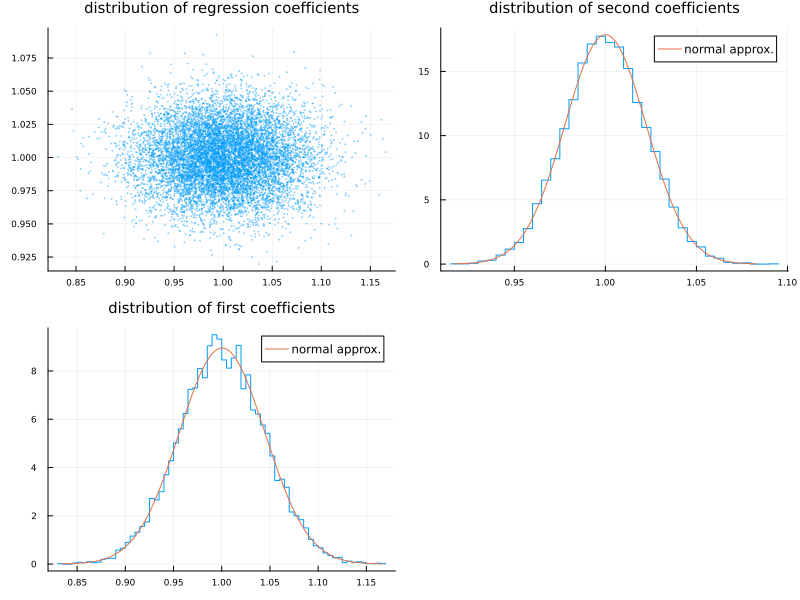

In [7]:
n = 1000
β̂ = sim(distx, a, b, distu, n)
@show mvnormalapprox_true(distx, a, b, distu, n)
@show fit(MvNormal, stack(β̂))

β̂₀, β̂₁ = getindex.(β̂, 1)[1:10000], getindex.(β̂, 2)[1:10000]
Q1 = scatter(β̂₀, β̂₁; label="", msc=:auto, alpha=0.5, ms=1)
title!("distribution of regression coefficients")
Q2 = stephist(β̂₀; norm=true, label="")
plot!(fit(Normal, β̂₀); label="normal approx.")
title!("distribution of first coefficients")
Q3 = stephist(β̂₁; norm=true, label="")
plot!(fit(Normal, β̂₁); label="normal approx.")
title!("distribution of second coefficients")

plot(Q1, Q3, Q2; size=(800, 600))

以上は標本サイズが $n=1000$ の場合である. 標本サイズが $n=10, 20$ 程度だと正規分布近似の誤差が見える程度になる.

In [8]:
function plot_betahat(; distx, a, b, distu, n, L=10^5)
    @show distx
    @show distu
    @show n
    println()
    
    β̂ = sim(distx, a, b, distu, n; L)
    @show mvnormalapprox_true(distx, a, b, distu, n)
    @show fit(MvNormal, stack(β̂))

    β̂₀, β̂₁ = getindex.(β̂, 1)[begin:min(end,10000)], getindex.(β̂, 2)[begin:min(end,10000)]
    Q1 = scatter(β̂₀, β̂₁; label="", msc=:auto, alpha=0.5, ms=1)
    title!("distribution of regression coefficients")
    Q2 = stephist(β̂₀; norm=true, label="")
    plot!(fit(Normal, β̂₀); label="normal approx.")
    title!("distribution of first coefficients")
    Q3 = stephist(β̂₁; norm=true, label="")
    plot!(fit(Normal, β̂₁); label="normal approx.")
    title!("distribution of second coefficients")

    plot(Q1, Q3, Q2; size=(800, 600))
end

plot_betahat (generic function with 1 method)

distx = Normal{Float64}(μ=0.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 10

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.2 -0.0; -0.0 0.05]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [0.9988563384553677, 1.0003156547033458]
Σ: [0.22711178586654676 -0.0006226773421056754; -0.0006226773421056754 0.07114590558832225]
)



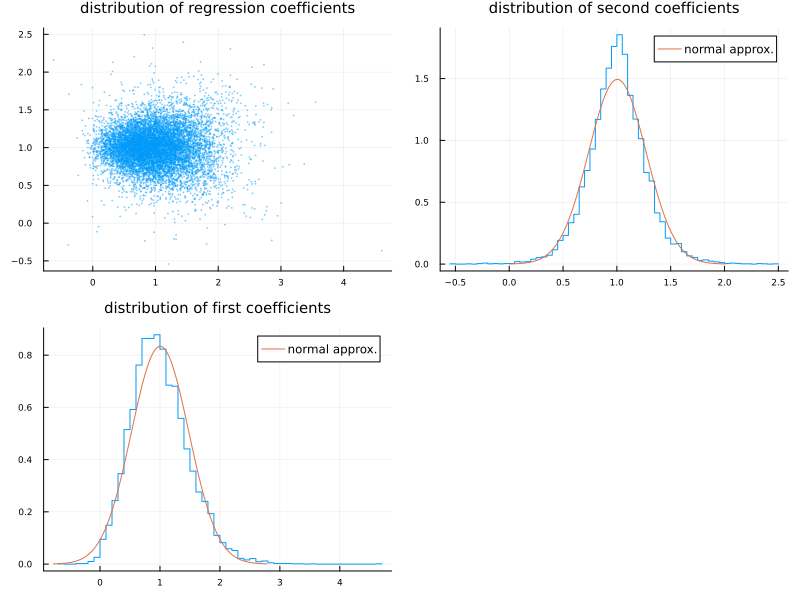

In [9]:
plot_betahat(; distx, a, b, distu, n=10)

distx = Normal{Float64}(μ=0.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 20

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.1 -0.0; -0.0 0.025]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [1.0007921976542855, 1.0005745102332326]
Σ: [0.10643799357310872 0.0001395310655172641; 0.0001395310655172641 0.029577609568935487]
)



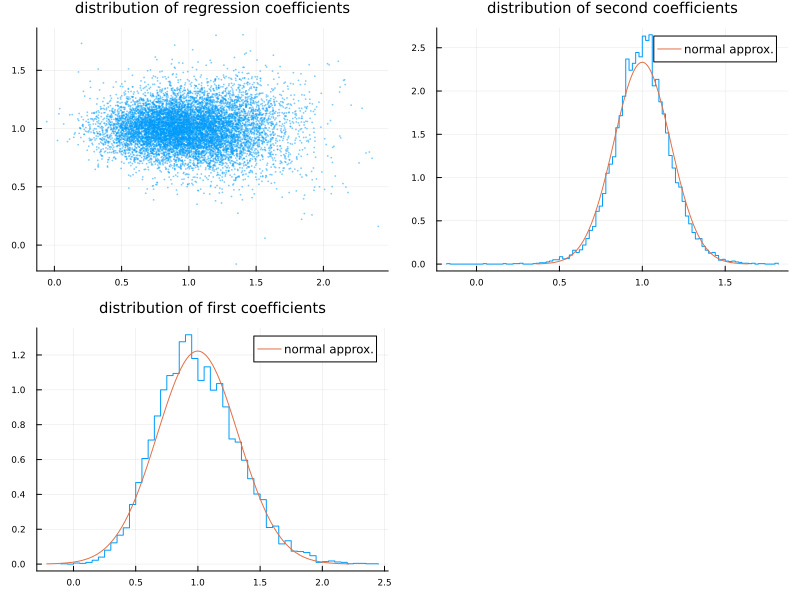

In [10]:
plot_betahat(; distx, a, b, distu, n=20)

distx = Normal{Float64}(μ=0.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 40

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.05 -0.0; -0.0 0.0125]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [0.9996023707982288, 0.9994604080754417]
Σ: [0.051111919167862944 0.00018326425571731656; 0.00018326425571731656 0.01346258381023967]
)



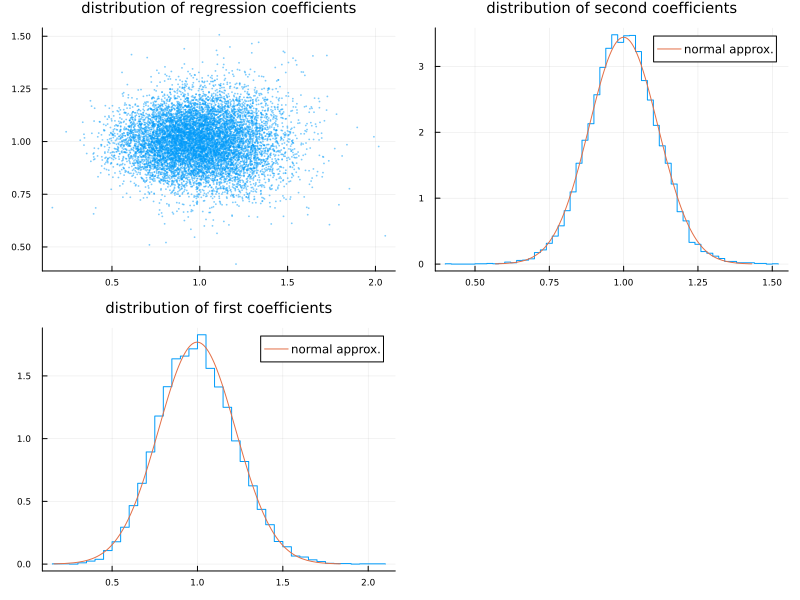

In [11]:
plot_betahat(; distx, a, b, distu, n=40)

distx = Normal{Float64}(μ=0.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 100

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.02 -0.0; -0.0 0.005]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [1.0006244198551892, 1.0003341194216904]
Σ: [0.02032545654635264 1.4700238931133596e-5; 1.4700238931133596e-5 0.005173863029488208]
)



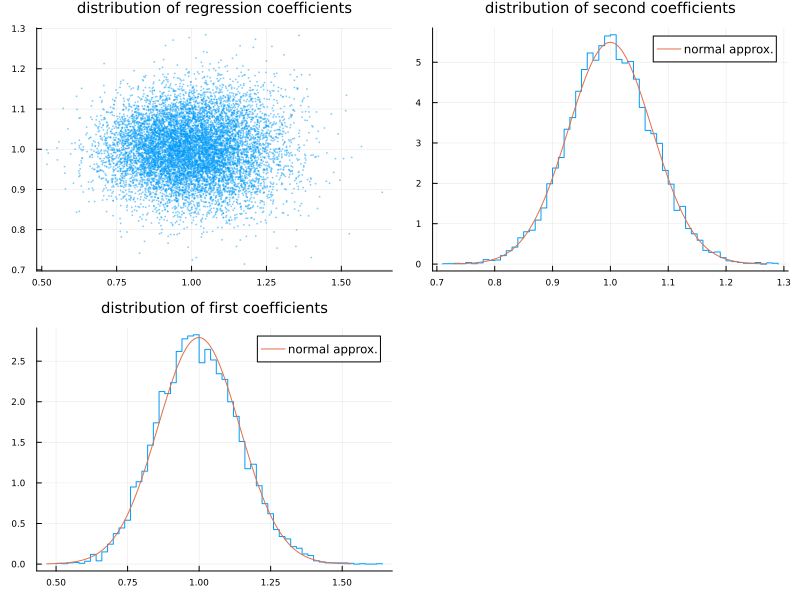

In [12]:
plot_betahat(; distx, a, b, distu, n=100)

このようにi.i.d.の残差の分布が正規分布でなくても, 標本サイズが十分に大きければ, 回帰係数の分布は多変量正規分布で近似される.

distx = Normal{Float64}(μ=2.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 10

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.4 -0.1; -0.1 0.05]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [0.9994595369173677, 0.9999331372181965]
Σ: [0.5111328437686499 -0.14172925149909707; -0.14172925149909707 0.07102169991759381]
)



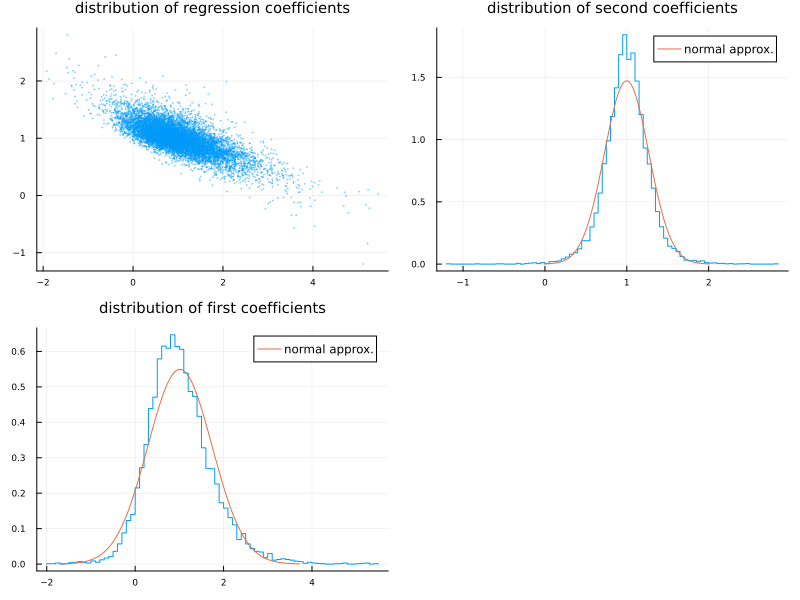

In [13]:
plot_betahat(; distx=Normal(2, 2), a, b, distu, n=10)

distx = Normal{Float64}(μ=2.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 20

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.2 -0.05; -0.05 0.025]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [0.9988853675590555, 0.9998933261925995]
Σ: [0.2229307080278284 -0.058889641036803456; -0.058889641036803456 0.029449198166490366]
)



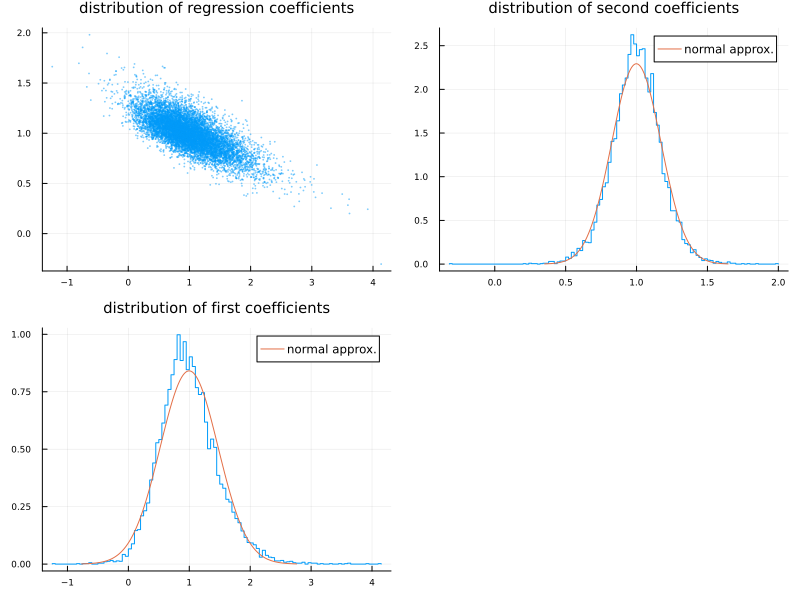

In [14]:
plot_betahat(; distx=Normal(2, 2), a, b, distu, n=20)

distx = Normal{Float64}(μ=2.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 40

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.1 -0.025; -0.025 0.0125]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [1.0001034834821305, 0.9997498195238936]
Σ: [0.10629540988277339 -0.027128739349217453; -0.027128739349217453 0.013505376014794034]
)



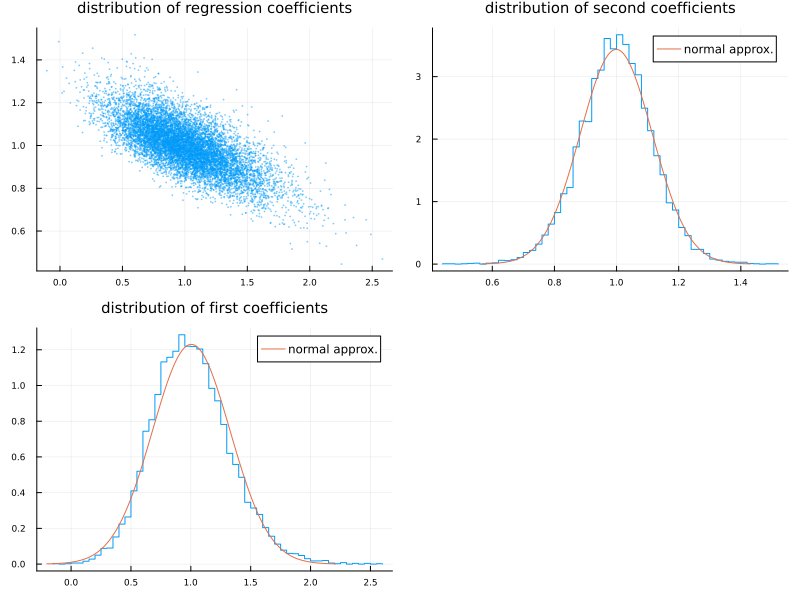

In [15]:
plot_betahat(; distx=Normal(2, 2), a, b, distu, n=40)

distx = Normal{Float64}(μ=2.0, σ=2.0)
distu = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -2.0
σ: 1.0
ρ: Gamma{Float64}(α=2.0, θ=1.0)
)

n = 100

mvnormalapprox_true(distx, a, b, distu, n) = FullNormal(
dim: 2
μ: [1.0, 1.0]
Σ: [0.04 -0.01; -0.01 0.005]
)

fit(MvNormal, stack(β̂)) = FullNormal(
dim: 2
μ: [0.9996722952715547, 1.000071159229083]
Σ: [0.04072307543891277 -0.010321542312522292; -0.010321542312522292 0.005173879040206012]
)



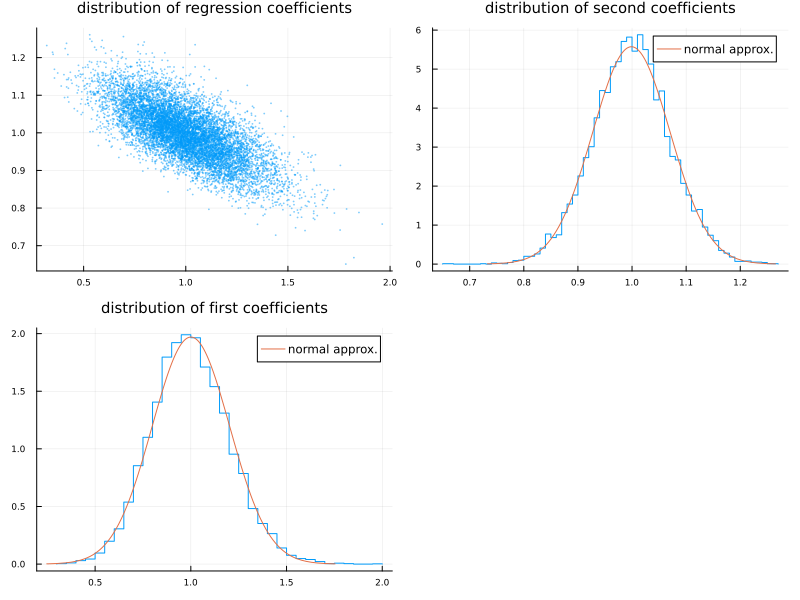

In [16]:
plot_betahat(; distx=Normal(2, 2), a, b, distu, n=100)